## CNN-MNIST Prediction
#### 05/08/2020

In [1]:
import numpy as np
import torch
import torchvision
import torch.nn.functional as F
from torch import nn,optim
import matplotlib.pyplot as plt

### Get the dataset through 'torchvision'
### Use 'transforms' to process the raw data

In [2]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.1307],[0.3081])
])

batchsize = 64

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset,batch_size=batchsize,shuffle=True,num_workers=2)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batchsize, shuffle=True, num_workers=2)

### Convolution, Pooling & Linear Layers; Dropout for preventing overfitting

In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.conv1 = nn.Conv2d(1,4,5)
        self.conv2 = nn.Conv2d(4,16,3)
        self.pool = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(5*5*16,128)
        self.fc2 = nn.Linear(128,32)
        self.fc3 = nn.Linear(32,10)
        self.dp2d = nn.Dropout2d(0.2)
        self.dp1d = nn.Dropout(0.2)
        
    def forward(self,x):
        batch_size = x.size()[0]
        x = self.dp2d(self.pool(self.conv1(x)))
        x = self.dp2d(self.pool(self.conv2(x)))
        x = x.view(batch_size,-1)
        x = self.dp1d(F.relu(self.fc1(x)))
        x = self.dp1d(F.relu(self.fc2(x)))
        x = self.fc3(x)
        return x
    
net = Net()

In [4]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(),lr=0.005)
loss_list = []
loss_list_test = []
percentage = []

### Every 10 epoches, we change the learning rate so that help train the net
- From the very first beginning, set lr = 0.001;
- Then reduce it to be 0.0003, 0.0001 and 0.00001

In [14]:
optimizer = optim.Adam(net.parameters(),lr=0.00001)

running_loss = 0
for e in range(10):
    for inputs,labels in iter(trainloader):
        net.train()
        optimizer.zero_grad()
        
        outputs = net(inputs)
        loss = criterion(outputs,labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    loss_list.append(running_loss/len(trainloader))
    running_loss = 0
    
    total = 0
    correct = 0
    with torch.no_grad():
        for inputs,labels in iter(testloader):
            net.eval()
            outputs = net(inputs)
            _,predicted = torch.max(outputs,dim=1)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            total += len(labels)
            correct += (predicted==labels).sum().item()
            
        loss_list_test.append(running_loss/len(testloader))
        percentage.append(correct/total)
        running_loss = 0
    
    print('epoch NO.{}\ttrainloss={:.5f}\ttestloss={:.5f}\t{:.3f}%'.format(e,loss_list[-1],loss_list_test[-1],percentage[-1]*100))

epoch NO.0	trainloss=0.04051	testloss=0.03419	99.070%
epoch NO.1	trainloss=0.03879	testloss=0.03403	99.070%
epoch NO.2	trainloss=0.03978	testloss=0.03397	99.080%
epoch NO.3	trainloss=0.03821	testloss=0.03404	99.090%
epoch NO.4	trainloss=0.04007	testloss=0.03404	99.100%
epoch NO.5	trainloss=0.03687	testloss=0.03404	99.080%
epoch NO.6	trainloss=0.03820	testloss=0.03393	99.100%
epoch NO.7	trainloss=0.03959	testloss=0.03404	99.110%
epoch NO.8	trainloss=0.03781	testloss=0.03560	99.100%
epoch NO.9	trainloss=0.03722	testloss=0.03387	99.100%


### The acuracy is pretty good

Text(0, 0.5, 'loss')

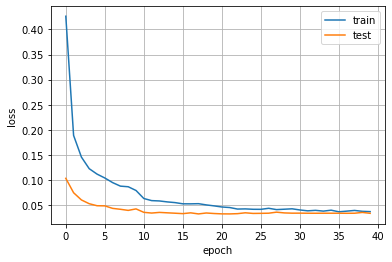

In [15]:
plt.plot(loss_list,label='train')
plt.plot(loss_list_test,label='test')
plt.legend()
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')

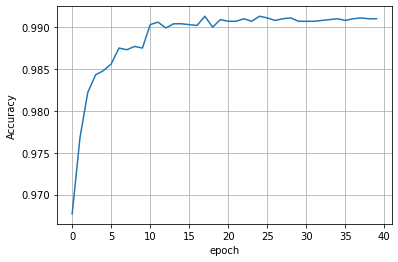

In [16]:
plt.plot(percentage)
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.grid()